In [1]:
from os import chdir
from glob import glob
import pandas as pd
import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

#bigdata = data1.append(data2, ignore_index=True)
#pd.concat([data1, data2], ignore_index=True, sort=False)



def mergeCSV(file_list):
    df_merge=pd.DataFrame()
    for file in file_list:
        df=pd.read_csv(file, header=None)
        df_merge=pd.concat([df, df_merge], ignore_index=True, sort=False)
    print(df_merge.shape)
    
    return df_merge


file_list=[]
for filepath in glob.iglob(r'C:/Users/antonebert/Desktop/WS2021 Programing/MADI/Activity Recognition from Single Chest-Mounted Accelerometer/*.csv'):
    file_list.append(filepath)

df_merged_csv=mergeCSV(file_list)


(1926896, 5)


In [2]:
df_merged_csv.head(-5)

,0,1,2,3,4
0,0.0,2287,2948,2189,1
1,1.0,2249,2677,2046,1
2,2.0,2270,2568,2005,1
3,3.0,2222,2565,2003,1
4,4.0,2235,2571,2074,1
...,...,...,...,...,...
1926886,162490.0,1927,2383,2079,7
1926887,162490.0,1931,2388,2076,7
1926888,162490.0,1932,2383,2072,7
1926889,162490.0,1931,2386,2073,7


In [3]:
df=df_merged_csv.drop(columns=[0])

In [4]:
df.shape

(1926896, 4)

In [5]:
df.head(-5)
df.columns=['x','y','z','label']

df_null=df[df["label"] == 0] #data cleaning: Leaving out unlabeled data || (3719, 4)
df_null.head()
print(df_null.shape)
df=df[df['label']>0]
df.shape

(3719, 4)


(1923177, 4)

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Data are separated by participant
Each file contains the following information
sequential number, x acceleration, y acceleration, z acceleration, label
Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing


#### Class Distribution 

Text(0.5, 1.0, 'Class Wise Sample Distribution')

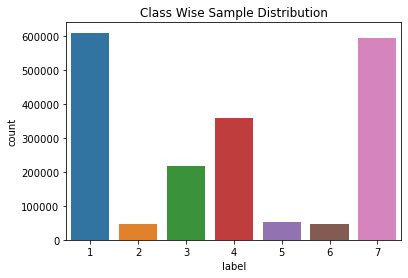

In [8]:
sns.countplot(x = 'label', data=df).set_title('Class Wise Sample Distribution')

<AxesSubplot:xlabel='label', ylabel='count'>

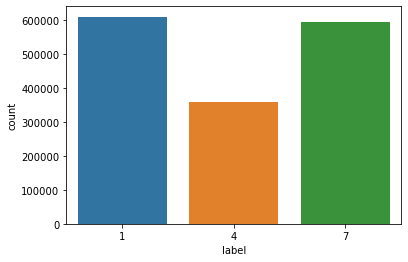

In [9]:
# For Class 1, 4 and 7
options=[1,4,7]
df3class= df.loc[df['label'].isin(options)]
sns.countplot(x = 'label', data=df3class)

In [10]:
X = df3class.iloc[:, 0:-1]
y = df3class.iloc[:, -1]
print(X.shape)

(1559294, 3)


<bound method NDFrame.head of             x     y     z  label
0        1969  2373  2121      1
1        1971  2373  2125      1
2        1961  2343  2099      1
3        2019  2352  1873      1
4        1894  2339  1846      1
...       ...   ...   ...    ...
1071187  2127  2519  2177      7
1071188  1887  2380  1980      7
1071189  2186  2366  1905      7
1071190  2002  2483  1964      7
1071191  1964  2523  2065      7

[1071192 rows x 4 columns]>


<AxesSubplot:xlabel='label', ylabel='count'>

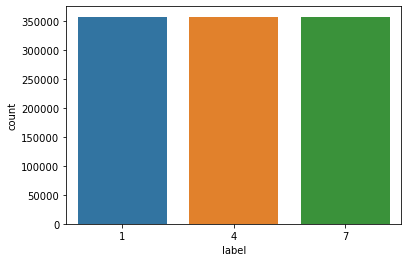

In [11]:
rus= RandomUnderSampler(random_state=0)
rus.fit(X,y)
X_resampled, y_resampled = rus.fit_sample(X,y)
#print(X_resampled.head)
#print(y_resampled.head)
df_resample = pd.concat([X_resampled,y_resampled], axis = 1)
print(df_resample.head)
sns.countplot(x = 'label', data=df_resample)

#### Encode Output
Pytorch supports labels from 0. [0,n]
- Dictionary class2idx , .replace method to change it, idx2class for reverse mapping

In [12]:
class2idx = {
    1:0,
    4:1,
    7:2
}

idx2class = {v: k for k, v in class2idx.items()}  # will be used later for reverse mapping

df['label'].replace(class2idx, inplace=True)

In [13]:
df.head(-5)

,x,y,z,label
0,2287,2948,2189,0
1,2249,2677,2046,0
2,2270,2568,2005,0
3,2222,2565,2003,0
4,2235,2571,2074,0
...,...,...,...,...
1926885,1931,2383,2076,2
1926886,1927,2383,2079,2
1926887,1931,2388,2076,2
1926888,1932,2383,2072,2


In [14]:
#Create input output data
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

#### Stratification
Let’s assume you are doing a multiclass classification and have an imbalanced dataset that has 5 different classes. You do a simple train-test split that does a random split totally disregarding the distribution or proportions of the classes. What happens in this scenario is that you end up with a train and a test set with totally different data distributions. A model trained on a vastly different data distribution than the test set will perform inferiorly at validation. 
For more info: https://towardsdatascience.com/3-things-you-need-to-know-before-you-train-test-split-869dfabb7e50

In [15]:
# Split into train+val (80%) and test(20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=69) 

# Split train into train-val(train 72%, val 8%)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify=y_trainval, random_state=21)


#### fit: transform: fit_transform:

"fit" computes the mean and std to be used for later scaling. (just a computation), nothing is given to you. 
"transform" uses a previously computed mean and std to autoscale the data (subtract mean from all values and then divide it by std). 
"fit_transform" does both at the same time.

#### Note:
We use .fit_transform() on X_train while we use .transform() on X_val and X_test.
We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage.


In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train) #mean and std used later to autoscale
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

## Neural Network

In [18]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [21]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
print(target_list)
target_list = target_list[torch.randperm(len(target_list))]
print(target_list)
print(target_list.shape)

tensor([2, 2, 0,  ..., 3, 2, 0])
tensor([2, 0, 0,  ..., 1, 0, 2])
torch.Size([1076978])


In [22]:
EPOCHS = 20
BATCH_SIZE = 156
LEARNING_RATE = 0.07
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 3

#### Dataloader

In [23]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE
                          #sampler=weighted_sampler  ## Random Sampler might be used
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

#### Define Neural Net Architechture

In [24]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        #self.layer_2 = nn.Linear(512, 512)
        self.layer_3 = nn.Linear(512, 256)
        #self.layer_4 = nn.Linear(256,256)
        self.layer_5 = nn.Linear(256,128)
        self.layer_6 = nn.Linear(128,64)
        self.layer_7 = nn.Linear(64,32)
        self.layer_out = nn.Linear(32, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.50)
        self.batchnorm1 = nn.BatchNorm1d(512)
        #self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(256)
        #self.batchnorm4 = nn.BatchNorm1d(256)
        self.batchnorm5 = nn.BatchNorm1d(128)
        self.batchnorm6 = nn.BatchNorm1d(64)
        self.batchnorm7 = nn.BatchNorm1d(32)
        
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        

        x = self.layer_5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_6(x)
        x = self.batchnorm6(x)
        x = self.relu(x)
        x = self.dropout(x)
                      
        x = self.layer_7(x)
        x = self.batchnorm7(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=128, bias=True)
  (layer_6): Linear(in_features=128, out_features=64, bias=True)
  (layer_7): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


#### Train Model

In [28]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [29]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [30]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 0.81043 | Val Loss: 0.67337 | Train Acc: 96.929| Val Acc: 60.269
Epoch 002: | Train Loss: 0.77284 | Val Loss: 0.75553 | Train Acc: 99.870| Val Acc: 58.376
Epoch 003: | Train Loss: 0.80911 | Val Loss: 0.56059 | Train Acc: 99.942| Val Acc: 63.769
Epoch 004: | Train Loss: 0.75768 | Val Loss: 0.55007 | Train Acc: 99.913| Val Acc: 64.101
Epoch 005: | Train Loss: 0.88513 | Val Loss: 0.71181 | Train Acc: 99.971| Val Acc: 61.330
Epoch 006: | Train Loss: 0.75114 | Val Loss: 1.10838 | Train Acc: 99.928| Val Acc: 58.729
Epoch 007: | Train Loss: 0.65553 | Val Loss: 0.63673 | Train Acc: 99.928| Val Acc: 64.805
Epoch 008: | Train Loss: 0.79527 | Val Loss: 0.47778 | Train Acc: 100.000| Val Acc: 67.639
Epoch 009: | Train Loss: 0.78791 | Val Loss: 0.51606 | Train Acc: 99.899| Val Acc: 65.121
Epoch 010: | Train Loss: 0.76589 | Val Loss: 0.55362 | Train Acc: 99.971| Val Acc: 68.944
Epoch 011: | Train Loss: 0.74410 | Val Loss: 0.67364 | Train Acc: 99.942| Val Acc: 66.497
Epoch 012

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

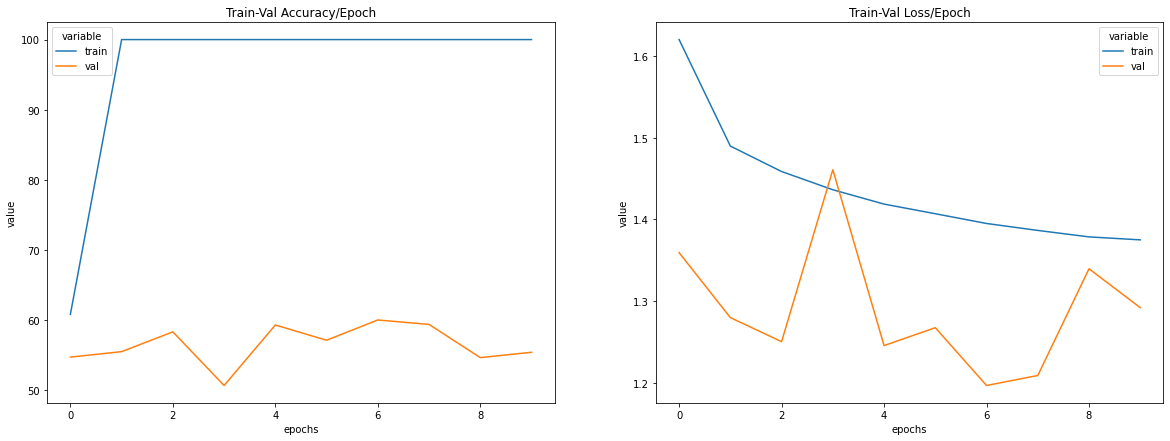

In [32]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [33]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

        1      2      3      4      5      6      7
1  122082  32552   3884   8002  11009    663   4408
2    2274   7289    899   2429    648    210    615
3    3372   3708  24180  12398  13443   4043   3877
4    6734   5445   8790  64983  13979   3237   3951
5    1117    309    587   4573   7435    768    661
6     594    485    976   2078   2679   6492   1027
7   11777   9193  21471  13976  16291  18581  86780


<AxesSubplot:>

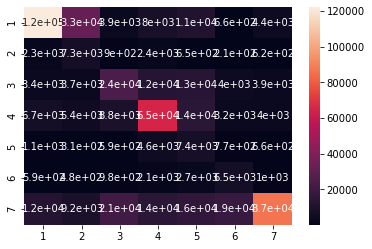

In [34]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
print(confusion_matrix_df)
sns.heatmap(confusion_matrix_df, annot=True)

<AxesSubplot:>

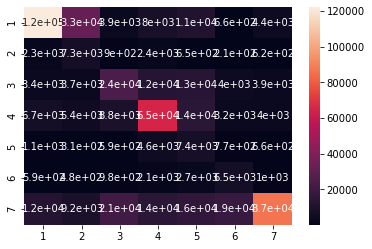

In [35]:
sns.heatmap(confusion_matrix_df, annot=True)

In [36]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74    182600
           1       0.12      0.51      0.20     14364
           2       0.40      0.37      0.38     65021
           3       0.60      0.61      0.60    107119
           4       0.11      0.48      0.18     15450
           5       0.19      0.45      0.27     14331
           6       0.86      0.49      0.62    178069

    accuracy                           0.55    576954
   macro avg       0.44      0.51      0.43    576954
weighted avg       0.69      0.55      0.60    576954



0: Working at Computer

1: x Standing Up, Walking and Going updown stairs x

2: Standing

3: Walking

4: x Going UpDown Stairs x

5: x Walking and Talking with Someone x

6: Talking while Standing

Data are separated by participant
Each file contains the following information sequential number, x acceleration, y acceleration, z acceleration, label Labels are codified by numbers

1: Working at Computer

2: Standing Up, Walking and Going updown stairs

3: Standing

4: Walking

5: Going UpDown Stairs

6: Walking and Talking with Someone

7: Talking while Standing

### Model Outbput
LR: 0.0007
Batch Size=16
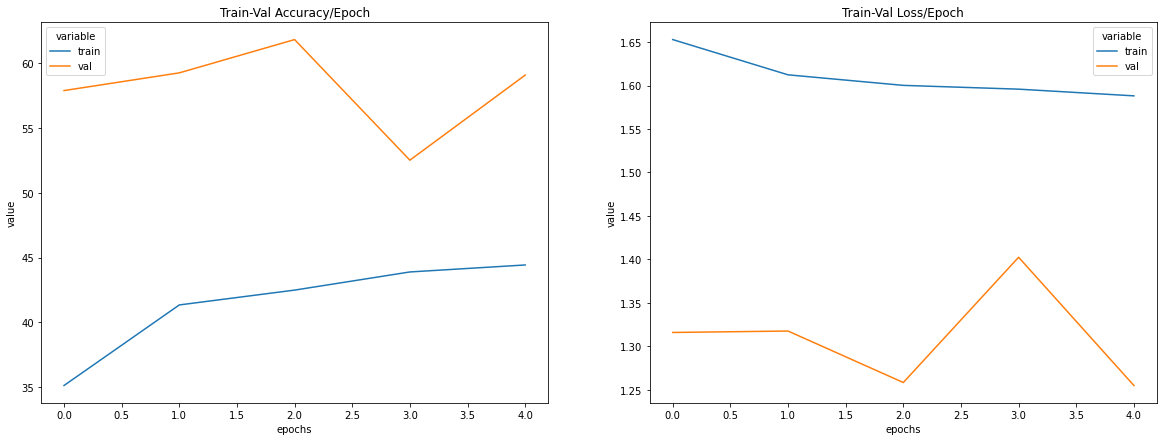


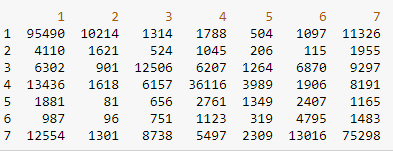


BS=512, LR=0.07, Epoc = 5
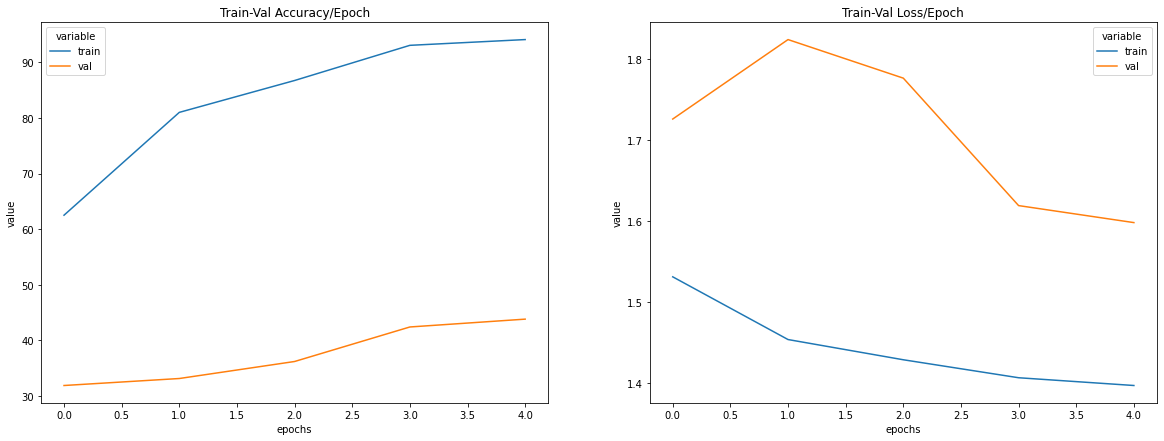



EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 7
MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=256, bias=True)
  (layer_4): Linear(in_features=256, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=128, bias=True)
  (layer_6): Linear(in_features=128, out_features=64, bias=True)
  (layer_7): Linear(in_features=64, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=7, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    
40%
8/20 [1:39:44<2:28:43, 743.63s/it]
Epoch 001: | Train Loss: 1.45580 | Val Loss: 1.12451 | Train Acc: 85.284| Val Acc: 62.810
Epoch 002: | Train Loss: 1.35409 | Val Loss: 1.08650 | Train Acc: 98.928| Val Acc: 62.834
Epoch 003: | Train Loss: 1.32242 | Val Loss: 1.11256 | Train Acc: 99.094| Val Acc: 59.435
Epoch 004: | Train Loss: 1.30231 | Val Loss: 1.10213 | Train Acc: 99.593| Val Acc: 60.403
Epoch 005: | Train Loss: 1.29343 | Val Loss: 1.08004 | Train Acc: 99.482| Val Acc: 61.022
Epoch 006: | Train Loss: 1.27908 | Val Loss: 1.11937 | Train Acc: 99.797| Val Acc: 59.552
Epoch 007: | Train Loss: 1.27378 | Val Loss: 1.06058 | Train Acc: 99.612| Val Acc: 61.269
Epoch 008: | Train Loss: 1.26883 | Val Loss: 1.05997 | Train Acc: 99.704| Val Acc: 62.432

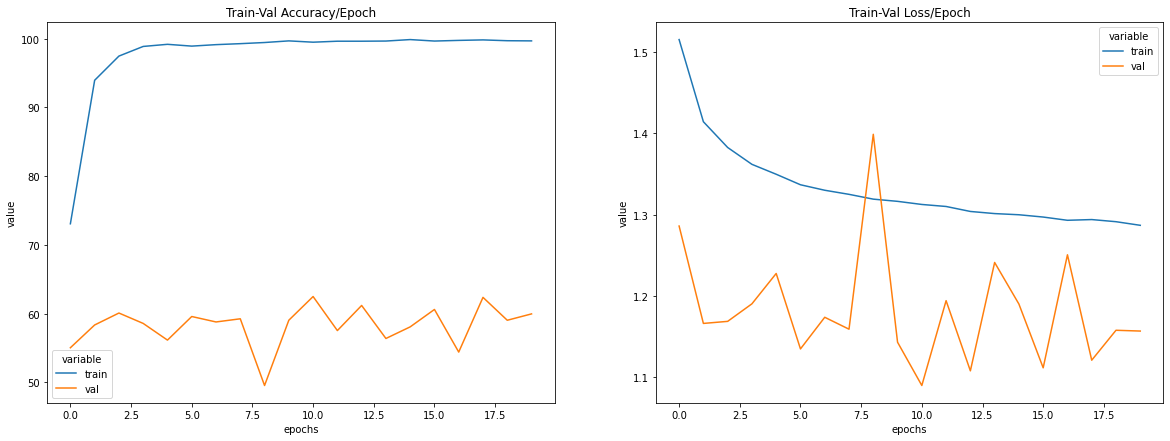